# Setup and imports

In [2]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from pennylane import qchem
import networkx as nx
from datetime import datetime 

In [3]:
C1 = qml.PauliX(1) @ qml.PauliZ(2) + qml.PauliX(0) + qml.PauliX(0) @ qml.PauliZ(2) 
C2 = qml.PauliX(0) @ qml.PauliZ(1) + qml.PauliZ(1) 
C3 = qml.PauliX(0) @ qml.PauliY(1) @ qml.PauliX(2) + qml.PauliX(0) @ qml.PauliX(2)

terms = [*C1, *C2, *C3]

np.random.seed(66)
n_qubits = 3
coeffs = np.round(np.random.rand(len(terms)), 2)

H = qml.Hamiltonian(coeffs, terms, grouping_type="qwc")

print("Hamiltonian:")
print(H)

Hamiltonian:
0.15 * (X(1) @ Z(2)) + 0.13 * X(0) + 0.36 * (X(0) @ Z(2)) + 0.68 * (X(0) @ Z(1)) + 0.19 * Z(1) + 0.25 * (X(0) @ Y(1) @ X(2)) + 0.76 * (X(0) @ X(2))


Some useful functios to plot QWC-graphs

In [4]:
def format_pauli_word(term):
    """Convenience function that nicely formats a PennyLane
    tensor observable as a Pauli word"""
    # check if term is product of Paulis
    if isinstance(term, qml.ops.Prod):
        return " ".join([format_pauli_word(t) for t in term])

    elif isinstance(term, qml.Identity):
        return f"I{term.wires.tolist()[0]}"
    return f"{term.name[-1]}{term.wires.tolist()[0]}"



def plot_qwc_graph(terms, groupings={}):
    """
    Function to create a graph of the QWC terms of the Hamiltonian.
    
    Args:
        terms (list): List of terms of the Hamiltonian.
        groupings (dict): Dictionary of groupings for the terms.
    Returns:
        None
    """
    G = nx.Graph()
    G.add_nodes_from(terms)
    
    for i in range(len(terms)):
        for j in range(i, len(terms)):
            if i != j and qml.pauli.are_pauli_words_qwc([terms[i], terms[j]]):
                G.add_edge(terms[i], terms[j])
    
    colors = mpl.colormaps['Set2'].colors
    if groupings:
        node_colors = [colors[groupings[node]] for node in G]
    else:
        node_colors = [colors[0]] * len(G.nodes())
    
    plt.margins(x=0.1)
    coords = nx.spring_layout(G, seed=66) # positions for all nodes to display them better
    nx.draw(
        G,
        coords,
        labels={node: format_pauli_word(node) for node in terms},
        with_labels=True,
        node_size=500,
        font_size=8,
        node_color=node_colors,
        edge_color="#c1c1c1",
    )
    plt.show()


def qwc_groups_to_dict(groupings):
    """
    Convert the groupings from the QML format to a dictionary format.
    """
    groupings_dict = {}
    for i, group in enumerate(groupings):
        for term in group:
            groupings_dict[term] = i
    return groupings_dict

In [5]:
H.grouping_indices
grouped_obs = [[H.ops[i] for i in indices] for indices in H.grouping_indices]
for i, group in enumerate(grouped_obs):
    print(f"Group {i}: {[format_pauli_word(obs) for obs in group]}")

Group 0: ['X1 Z2', 'X0', 'X0 Z2']
Group 1: ['X0 Z1', 'Z1']
Group 2: ['X0 Y1 X2', 'X0 X2']


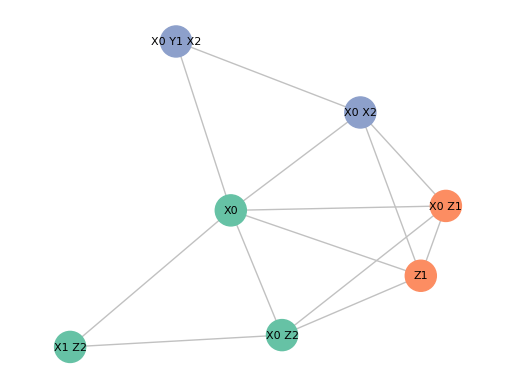

In [6]:
plot_qwc_graph(terms, qwc_groups_to_dict(qml.pauli.group_observables(terms, grouping_type="qwc")))

Define weight function. We are given a Hamiltonian $H$ decomposed as $H = (h_i, O^{(i)})$, where each $O^{(i)}$ is an $n$-qubit Pauli string $O^{(i)} \in \{\text{Id}, X, Y, Z\}^{\otimes n}$, and a measurement scheme $\boldsymbol{Q} = (Q_1, \dots, Q_N)$, where $Q_i \in \mathcal{P}^{\otimes n}$. We define
$$
N_i(\boldsymbol{Q}) := \sum_{i=1}^N \mathcal{C}_{\text{QWC}}(Q_j, O^{(i)}),
$$
which is the number of measurements in the measurement scheme $\boldsymbol{Q}$ that are compatible with the observable $O^{(i)}$. Then, the weight function takes the **Hamiltonian decomposition** and a list of **previous measurement settings** as inputs and outputs a non-negative weight $w_i$ for each Pauli string $O^{(i)}$ in the decomposition of $H$. This weight is defined as follows:
$$
w_i(\boldsymbol{Q}, H) := |h_i| \frac{\sqrt{N_i + 1} - \sqrt{N_i}}{\sqrt{N_i (N_i + 1)}}
$$

In [7]:
# def get_obs_weights(Q, H):
#     """Funcion to calculate the weights of the Pauli strings in the Hamiltonian decomposition.
#     The weights are calculated using the formula:
#     w_i = |h_i| * (sqrt(N_i+1) - sqrt(N_i)) / (sqrt(N_i*(N_i+1)))
#     where h_i is the coefficient of the term $O^{(i)}$ in the decomposition, and N_i is the number of measurements
#     in the measurement scheme $\boldsymbol{Q}$ that are compatible with the observable $O^{(i)}$.

#     Args:
#         Q (list): previous measurement scheme.
#         H (qml.hamiltonian): Hamiltonian written in terms of Pauli strings.

#     Returns:
#         _type_: list of weights for each term in the Hamiltonian.
#     """
#     weights = []
#     for i in range(len(H.ops)):
#         Oi = H.ops[i]
#         Ni = sum([qml.pauli.are_pauli_words_qwc([Q[j], Oi]) for j in range(len(Q))])
#         if Ni == 0:
#             Ni = 1
#         # print(Ni)
#         weights.append(np.abs(H.coeffs[i]) * (np.sqrt(Ni+1) - np.sqrt(Ni)) / (np.sqrt(Ni*(Ni+1))))
#     return weights

# Q = [qml.Identity(wires=range(n_qubits))]

# weights = get_obs_weights(Q, H)
# print("Weights:")
# print(np.array(weights).real)
# print(np.dot(coeffs, (np.sqrt(2) - 1) / (np.sqrt(2))))

### ShadowGrouping

We start with an idle measurment setting $Q = \text{Id}^{\otimes n}$. First, we order the observables in the decomposition of $H$ by their weight. If $O$ is the next element of this list, we check wheter $\mathcal{C}_{\text{QWC}}(O, Q)$. If they do, then we allow changing the idle parts of $Q$ to match the respective parts of $O$. E.g. $\mathcal{C}_{\text{QWC}}(X \otimes \text{Id}, \text{Id} \otimes Y) = 1$, so we would change $\text{Id} \otimes Y$ to $X \otimes Y$. Otherwise, we jump to the next observable in the list. Eventually, we have either no more idle parts in $Q$ left to change or all observables $O$ have been checked. We thus obtain the measurement setting $Q$ that directly tells us in which Pauli basis we should measure each qubit. Finally, we recalculate the weights based on the measurement scheme obtained by adding this measurement setting.

Old versions

In [8]:
# def get_obs_weights(Q, H):
#     """Function to calculate the weights of the Pauli strings in the Hamiltonian decomposition.
#     The weights are calculated using the formula:
#     w_i = |h_i| * (sqrt(N_i+1) - sqrt(N_i)) / (sqrt(N_i*(N_i+1)))
#     where h_i is the coefficient of the term $O^{(i)}$ in the decomposition, and N_i is the number of measurements
#     in the measurement scheme $\boldsymbol{Q}$ that are compatible with the observable $O^{(i)}$.

#     Args:
#         Q (list): previous measurement scheme.
#         H (qml.hamiltonian): Hamiltonian written in terms of Pauli strings.

#     Returns:
#         _type_: list of weights for each term in the Hamiltonian.
#     """
#     coeffs, H = H
    
#     weights = np.zeros(len(H))
#     for i in range(len(H)):
#         Oi = H[i]
#         Ni = sum([are_pauli_words_qwc(Q[j], Oi) for j in range(len(Q))])

#         if Ni == 0:
#             Ni = 1
#         # print(Ni)
#         weights[i] = np.abs(coeffs[i]) * (np.sqrt(Ni+1) - np.sqrt(Ni)) / (np.sqrt(Ni*(Ni+1)))
#     return weights



# def get_measurement_scheme(Ham, n_shots, return_weights=False, return_compat_obs=False):
#     """Function to obtain the measurement scheme for the Hamiltonian H.
#     The measurement scheme is obtained by first ordering the terms in H
#     by their weight and then iteratively replacing the Identity
#     operators in the measurement setting with the terms of the Hamiltonian
#     that are compatible with the measurement setting.

#     Args:
#         H (qml.hamiltonian): Hamiltonian written in terms of Pauli strings.
#         n_shots (int): number of shots to be used in the measurement scheme.

#     Returns:
#         list: measurement scheme (list of measurement settings).
#     """
    
#     now = datetime.now()
    
#     H = Ham[1]
    
#     n_qubits = H.shape[1]
#     meas_scheme = np.zeros((n_shots, n_qubits), dtype=int)
#     weights_tracker = np.zeros((n_shots, len(H)), dtype=float)
    
#     for i in range(n_shots):
#         # initialize measurement setting to be the identity
#         Q = np.zeros(n_qubits, dtype=int)
        
#         # obtain weights from previous measurement scheme
#         weights = get_obs_weights(meas_scheme[:i], Ham)

#         if return_weights:
#             weights_tracker[i] = weights        
        
#         # print("Weights", weights)
#         # sort terms of the Hamiltonian by descending weight
#         sorted_indices = np.argsort(weights)[::-1]
#         sorted_terms = H[sorted_indices]
        
#         # print("Sorted Terms:", sorted_terms)
#         # print(H)
                
#         # print("Weights:", weights)
#         n_changes = 0
        
#         for term in sorted_terms:
#             if n_changes >= n_qubits:
#                 break
            
#             # check QWC between current measurement setting and Hamiltonian term
#             if are_pauli_words_qwc(Q, term):
#                 # print(Q, term, "QWC")
#                 for j in range(n_qubits):
#                     if Q[j] == 0 and term[j] != 0:
#                         Q[j] = term[j]
#                         n_changes += 1
#                         if n_changes > n_qubits:
#                             break
#         meas_scheme[i, :] = Q
#         # print("Final Q:", Q)
    
#     # Optional: get, for each observable in H, the indexes in meas_scheme of the settings that QWC with that observable
#     obs_compat = np.zeros(len(H), dtype=object)
#     if return_compat_obs:
#         for i in range(len(H)):
#             compat_idxs = np.array(
#                 [i for i, Q in enumerate(meas_scheme) if are_pauli_words_qwc(H[i], Q)]
#                 )
#             obs_compat[i] = compat_idxs
    
#     finish = datetime.now()
#     print(f"Shots: {n_shots} \t Time for measurement scheme: {(finish - now).total_seconds()} s")
    
#     # returns
#     if return_weights and return_compat_obs:
#         return meas_scheme, weights_tracker, obs_compat
#     elif return_weights:
#         return meas_scheme, weights_tracker
#     elif return_compat_obs:
#         return meas_scheme, obs_compat
#     else:
#         return meas_scheme



# def get_measurement_scheme_old(H, n_shots, return_weights=False, return_compat_obs=False):
#     """Function to obtain the measurement scheme for the Hamiltonian H.
#     The measurement scheme is obtained by first ordering the terms in H
#     by their weight and then iteratively replacing the Identity
#     operators in the measurement setting with the terms of the Hamiltonian
#     that are compatible with the measurement setting.

#     Args:
#         H (qml.hamiltonian): Hamiltonian written in terms of Pauli strings.
#         n_shots (int): number of shots to be used in the measurement scheme.

#     Returns:
#         list: measurement scheme (list of measurement settings).
#     """
#     now = datetime.now()
    
#     n_qubits = len(H.wires)
#     meas_scheme = []
#     weights_tracker = [[] for _ in range(len(H.ops))]
    
#     for i in range(n_shots):

#         # initialize measurement setting to be the identity
#         Q = qml.ops.Prod(*[qml.Identity(wires=i) for i in range(n_qubits)])
        
#         # obtain weights from previous measurement scheme
#         weights = get_obs_weights(meas_scheme, format_hamiltonian(H))

#         if return_weights:
#             for i in range(len(weights)):
#                 weights_tracker[i].append(weights[i])        # sort terms of the Hamiltonian by their weights (in increasing order)
                
#         sorted_pairs = sorted(zip(weights, H.ops), key=lambda x: x[0], reverse=True)
#         sorted_terms = [obs for _, obs in sorted_pairs]

#         # print("Sorted Terms:")
#         # print(f"{"Term":<15} Weight")
#         # for term in sorted_terms:
#             # print(f"{format_pauli_word(term):15} {np.round(weights[H.ops.index(term)], 2)}")
#         # print()    

#         n_changes = 0 # track number of changes in measurement setting Q (cannot be larger than n_qubits))

#         for term in sorted_terms:
#             # there are no more Identities in Q to change
#             if n_changes >= n_qubits:
#                 break
            
#             # print(f"Term: {format_pauli_word(term)}")
#             # print(f"Q: {format_pauli_word(Q)}")
            
#             # store which operator acts on which wire
#             wire_to_op_dict = {}
#             if len(term.wires) > 1:
#                 wire_to_op_dict = dict(zip(term.wires, term.operands))
#             else:
#                 wire_to_op_dict = {term.wires[0]: term}
            
#             # if Q and Hamiltonian term are QWC, perform substitutions
#             if qml.pauli.are_pauli_words_qwc([Q, term]):
#                 # print(f"They are QWC!")
#                 # Replace individual components
#                 Q_ops = list(Q.operands)
#                 # print("\t Q operands: ", Q_ops)
#                 # print("Substitutions:")
#                 # if operator component is Id, check if it can be replaced
#                 for (i, op) in enumerate(Q_ops):
#                     if isinstance(op, qml.Identity):
#                         op_wire = op.wires[0]
#                         # the wire in which operator component is Id must be the same as the wire in which the Hamiltonian term acts
#                         if op_wire in wire_to_op_dict:
#                             Q_ops[i] = wire_to_op_dict[op.wires[0]]
#                             n_changes += 1
#                             # print(f"\tQ_{i} -->", Q_ops[i])
#                 # update measurement scheme
#                 Q = qml.ops.Prod(*Q_ops)
#                 # print()
#             else:
#                 continue
#                 # print("NOT QWC!")
#             # print()

#         # print("Final Q:", format_pauli_word(Q))
#         meas_scheme.append(Q)
        

#     # get, for each observable in H, the indexes in meas_scheme of the settings that QWC with that observable    
#     if return_compat_obs:
#         obs_compat = []
#         for obs in H.ops:
#             compat_idxs = []
#             for k in range(len(meas_scheme)):
#                 if qml.pauli.are_pauli_words_qwc([obs, meas_scheme[k]]):
#                     compat_idxs.append(k)
#             # print(obs, " ", compat_idxs)
#             obs_compat.append(compat_idxs)
        
#     finish = datetime.now()
#     print(f"Shots: {n_shots} \t Time for measurement scheme: {(finish - now).total_seconds()} s")
#     # returns
#     if return_weights:
#         if return_compat_obs:
#             return meas_scheme, weights_tracker, obs_compat
#         else:
#             return meas_scheme, weights_tracker
#     elif return_compat_obs:
#         return meas_scheme, obs_compat
#     else:
#         return meas_scheme
    

# Measurement schemes

In [9]:

def format_pauli_string(op, n_qubits):
    """Format Pauli string as integers. E.g. X0 @ Z1 @ I2 -> [1, 3, 0]
    Args:
        op (qml.PauliX @ qml.PauliZ @ qml.Identity): Pauli string to be formatted.
        n_qubits (int): number of qubits in the system.
    Returns:
        np.array: array of integers representing the Pauli string.
    """
    
    pauli_map = {
        qml.PauliX: 1,
        qml.PauliY: 2,
        qml.PauliZ: 3,
        qml.Identity: 0,
    }
    
    pauli_array = np.zeros(n_qubits, dtype=int)
    
    # check if term is product of Paulis
    if isinstance(op, qml.ops.Prod):
        for sub_op in op:
            wire = sub_op.wires[0]
            pauli_array[wire] = pauli_map.get(type(sub_op), 0)

    # elif isinstance(op, qml.Identity):
    #     pass  # already all zeros

    # check if term is single Pauli operator
    else:
        wire = op.wires[0]
        pauli_array[wire] = pauli_map.get(type(op), 0)

    return pauli_array



def are_pauli_words_qwc(obs1, obs2):
    """Check qubit-wise commutativity between two Pauli strings in integer format.
    
    Args:
        pauli_a (np.ndarray): Array of integers representing Pauli string A.
        pauli_b (np.ndarray): Array of integers representing Pauli string B.
        
    Returns:
        bool: True if A and B are QWC, False otherwise.
    """
    
    for a, b in zip(obs1, obs2):
        if a == 0 or b == 0:
            continue # identity always commutes
        elif a != b:
            return False
    return True
        


def format_hamiltonian(H):
    """Format Hamiltonian as a list of Pauli strings in integer format.

    Args:
        H (qml.Hamiltonian): Hamiltonian to be formatted.
        n_qubits (int): number of qubits in the system.

    Returns:
        tuple (n_qubits, formatted Hamiltonian): Formatted Hamiltonian is an array representing the Hamiltonian. Each row is a Pauli string.
    """
    n_qubits = len(H.wires)
    ham = np.zeros((len(H.ops), n_qubits), dtype=int)
    for i in range(len(H.ops)):
        ham[i] = format_pauli_string(H.ops[i], n_qubits)
        
    return H.coeffs, ham



def get_measurement_scheme(Ham, n_shots, return_weights=False, return_compat_obs=False):
    """
    Function to obtain the measurement scheme for the Hamiltonian H.
    The measurement scheme is obtained by first ordering the terms in H
    by their weight and then iteratively replacing the Identity
    operators in the measurement setting with the terms of the Hamiltonian
    that are compatible with the measurement setting.

    Args:
        Ham (tuple): (coeffs, Pauli strings as int arrays), output of format_hamiltonian().
        n_shots (int): Number of measurement settings (rounds) to generate.
        return_weights (bool): If True, return weight history for each term.
        return_compat_obs (bool): If True, return observables compatible with each setting.

    Returns:
        meas_scheme: Array of integer-encoded measurement settings.
        Optionally: weights_tracker, obs_compat.
    """

    coeffs, H_ops = Ham
    n_terms, n_qubits = H_ops.shape

    now = datetime.now()

    meas_scheme = np.zeros((n_shots, n_qubits), dtype=int)  # Measurement settings
    weights_tracker = np.zeros((n_shots, n_terms)) if return_weights else None
    N = np.ones(n_terms, dtype=int)  # QWC counts per observable (start at 1 to avoid division by 0)

    for i in range(n_shots):
        # Efficient weight calculation using closed formula
        weights = np.abs(coeffs) * (np.sqrt(N + 1) - np.sqrt(N)) / np.sqrt(N * (N + 1))

        if return_weights:
            weights_tracker[i] = weights

        # Sort terms by descending weight
        sorted_indices = np.argsort(weights)[::-1]
        sorted_terms = H_ops[sorted_indices]

        Q = np.zeros(n_qubits, dtype=int)  # Start with identity on all qubits
        n_changes = 0

        # Fill in Q by trying to add high-weight compatible terms
        for term in sorted_terms:
            # Check if we have already filled all qubits
            if n_changes >= n_qubits:
                break

            if are_pauli_words_qwc(Q, term):
                # Substitute Pauli operators into available identity slots
                for j in range(n_qubits):
                    # if Q is identity on qubit j and the term is non-identity on qubit j, replace Q_j with term_j
                    if Q[j] == 0 and term[j] != 0:
                        Q[j] = term[j]
                        n_changes += 1
                        if n_changes >= n_qubits:
                            break

        # Store the new measurement setting
        meas_scheme[i] = Q  

        # Update QWC compatibility counts for each term
        for t in range(n_terms):
            if are_pauli_words_qwc(H_ops[t], Q):
                N[t] += 1

    # Optional: build list of compatible measurement settings per observable
    # Get, for each term in H, the indexes in meas_scheme of the settings that QWC with that observable
    obs_compat = None
    if return_compat_obs:
        obs_compat = np.empty(n_terms, dtype=object)
        for t in range(n_terms):
            compat_idxs = np.array(
                [i for i, Q in enumerate(meas_scheme) if are_pauli_words_qwc(H_ops[t], Q)]
            )
            obs_compat[t] = compat_idxs

    finish = datetime.now()
    print(f"Shots: {n_shots} \t Time for measurement scheme: {(finish - now).total_seconds()} s")

    # Return according to flags
    if return_weights:
        if return_compat_obs:
            return meas_scheme, weights_tracker, obs_compat
        else:
            return meas_scheme, weights_tracker
    elif return_compat_obs:
        return meas_scheme, obs_compat
    else:
        return meas_scheme

    


def Lp_norm(x, p):
    """Function to calculate the L1 norm of a vector.
    
    Args:
        x (list): vector to calculate the L1 norm of.
        
    Returns:
        float: L1 norm of the vector.
    """
    return np.linalg.norm(x, ord=p)
    
    
    
def get_error_bound(H, meas_scheme, delta):
    """Function to calculate error bound given failure probability.
    This is done using eq. (5) from the original paper.

    Args:
        H (qml.Hamiltonian): Hamiltonian written in terms of Pauli strings.
        meas_scheme (list): measurement scheme (list of measurement settings).
        delta (failure probability): p(|E - hat{E}| >= eps) < delta
        
    Returns:
        error bound (float): eps <= error bound.
    """
    
    # calculate how many settings in the measurement scheme are QWC with each term in the Hamiltonian
    N = []    
    for i in range(len(H.ops)):
        Oi = H.ops[i]
        Ni = sum([qml.pauli.are_pauli_words_qwc([obs, Oi]) for obs in meas_scheme])
        if Ni == 0:
            Ni = 1
        # print(Ni)
        N.append(Ni)

    h_prime = np.abs(H.coeffs) / np.sqrt(N)
    
    return 6 * np.log(Lp_norm(h_prime, 1) / delta)


In [10]:
# n_shots = 20

# Q = qml.Identity(wires=range(n_qubits))

# format_pauli_string(H.ops, n_qubits)
# print(H.ops)
# for op in H.ops:
#     print(format_pauli_string(op, n_qubits))
    
# print(are_pauli_words_qwc(format_pauli_string(H.ops[0], n_qubits), format_pauli_string(H.ops[3], n_qubits)))
# ham = format_hamiltonian(H)
# ham


# weights = get_obs_weights(np.array([format_pauli_string(Q, n_qubits)]), format_hamiltonian(H))
# print("Weights:")
# print(np.array(weights).real)
# print(np.dot(coeffs, (np.sqrt(2) - 1) / (np.sqrt(2))))

meas_scheme = get_measurement_scheme(format_hamiltonian(H), n_shots=1000)
# meas_scheme[0]
# meas_scheme_old = get_measurement_scheme_old(H, n_shots=1000, return_weights=False, return_compat_obs=False)

Shots: 1000 	 Time for measurement scheme: 0.568892 s


Plot weights evolution

Group 0: ['X1 Z2', 'X0', 'X0 Z2']
Group 1: ['X0 Z1', 'Z1']
Group 2: ['X0 Y1 X2', 'X0 X2']
['X1 Z2', 'X0', 'X0 Z2', 'X0 Z1', 'Z1', 'X0 Y1 X2', 'X0 X2']
[0.15 0.13 0.36 0.68 0.19 0.25 0.76]
Shots: 10 	 Time for measurement scheme: 0.014351 s


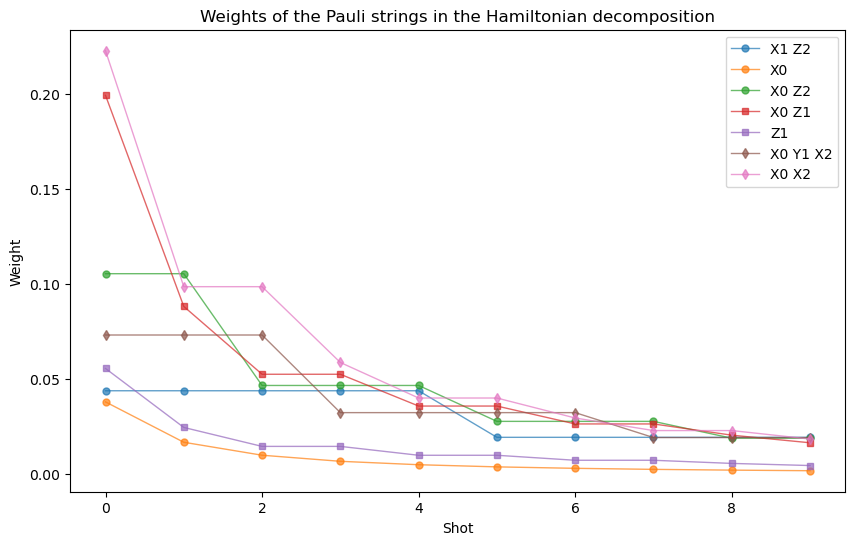

In [11]:
H.grouping_indices
grouped_obs = [[H.ops[i] for i in indices] for indices in H.grouping_indices]
for i, group in enumerate(grouped_obs):
    print(f"Group {i}: {[format_pauli_word(obs) for obs in group]}")

print([format_pauli_word(op) for op in H.ops])
print(H.coeffs)

meas_scheme, weights_tracker = get_measurement_scheme(Ham=format_hamiltonian(H), n_shots=10, return_weights=True)
weights_tracker = np.transpose(weights_tracker)

marker_dict = {}
markers = ['o', 's', 'd', '^', 'v', '<', '>', 'p', '*', 'h', 'H', '+', 'x', '|', '_']
for group_idx, group in enumerate(grouped_obs):
    for obs in group:
        marker_dict[obs] = markers[group_idx % len(markers)]


fig, ax = plt.subplots(figsize=(10, 6))

for i in range(len(weights_tracker)):
    ax.plot(weights_tracker[i], marker=marker_dict[H.ops[i]], markersize=5, alpha=0.7, lw=1, label=format_pauli_word(H.ops[i]))
    
ax.set_xlabel("Shot")
ax.set_ylabel("Weight")
ax.set_title("Weights of the Pauli strings in the Hamiltonian decomposition")
ax.legend()
plt.show()
fig.savefig(f"Plots/weights_10.png", dpi=800)

The measurement scheme elements of the list should QWC with the terms having the highest weight. For instance, in this plot, we see that $Q_0 = X_0 \otimes Z_1 \otimes X_2$ is QWC-compatible with the pink ($X_0\otimes X_2$) and the red ($X_0 \otimes Z_1$) terms. After these two, it has no more $\text{Id}$ left to change, so it goes to the next setting.

In the third shot, things start to change. Now the green ($X_0 \otimes Z_2$) term has the highest weight. So after the first step in the updating of $Q$, we will have $Q = X_0 \otimes \text{Id}_1 \otimes Z_2$. Now, the next term is the pink one ($X_0\otimes X_2$). But this is not QWC with Q, so we jump to the third highest-weight term, which is the red one ($X_0 \otimes Z_1$). This is QWC with $Q$, so that $Q_2 = X_0 \otimes Z_1 \otimes Z_2$.

Note also that each dot takes into account the previous measurement scheme. This is why the pink and the red, although having $N_i = 2$ after the second shot, this is taken into account during the third shot, so we see them decrease at shot number 3.  

# Estimating expected value

In [491]:
dev_ideal = qml.device("default.qubit", wires=n_qubits, shots=None)
dev = qml.device("lightning.qubit", wires=n_qubits, shots=1)

# circuit template to prepare the state
x = np.arange(2*n_qubits, dtype="float64")
def circuit():
    for i in range(n_qubits):
        qml.RY(x[i], wires=i)
    for i in range(n_qubits-1):
        qml.CNOT(wires=[i, i+1])
    for i in range(n_qubits):
        qml.RY(x[i+n_qubits], wires=i)    


# ideal device to calculate the exact expectation value of the Hamiltonian
@qml.qnode(dev_ideal)
def qnode_ideal():
    circuit()
    return qml.expval(H)

ideal_H = qnode_ideal()
print("Ideal H =", np.round(ideal_H, 5))


# circuit to prepare state
@qml.qnode(dev)
def qnode(observables):
    circuit()
    return [qml.expval(obs) for obs in observables]

# @qml.qnode(dev)
# def qnode(observable):
#     circuit()
#     return qml.expval(obs)

Ideal H = 0.05559


/opt/anaconda3/envs/plane/lib/python3.13/site-packages/pennylane/ops/op_math/composite.py:209: FutureWarning: functools.partial will be a method descriptor in future Python versions; wrap it in staticmethod() if you want to preserve the old behavior
  return self._math_op(math.vstack(eigvals), axis=0)


## Important Functions

In [545]:

def calculate_classical_shadow(circuit_template, meas_scheme):
    """
    Function to calculate the classical shadow of a quantum circuit.
    
    Args:
        circuit_template (function): circuit that prepares the quantum state.
        meas_scheme (list): measurement scheme.
        shadow_size (int): number of shots to be used in the measurement scheme.
        n_qubits (int): number of qubits in the circuit.
    
    Returns:
        array: classical shadow of the quantum circuit. (outcomes, recipes)
    """
    
    # use mapping to convert Pauli operators to integers
    pauli_map = {0: qml.Identity, 1: qml.PauliX, 2: qml.PauliY, 3: qml.PauliZ}
    shadow_size, n_qubits = meas_scheme.shape
    outcomes = np.zeros((shadow_size, n_qubits))
    
    # for each measurement setting in the measurement scheme, calculate the expectation value of the Pauli operators provided by the measurement setting
    for snapshot in range(shadow_size):
        obs = [pauli_map[int(meas_scheme[snapshot, i])](i) for i in range(n_qubits)]
        outcomes[snapshot] = circuit_template(obs)
        
    return (outcomes, meas_scheme)



def median_of_means(array, k=10):
    
    array_size = len(array)
    means = []
    # print(array_size)
    for i in range(0, array_size, array_size // k):
        # print(i)
        means.append(np.mean(array[i: i + array_size // k]))
    
    return np.median(means)




def estimate_hamiltonian(Ham, shadow, obs_compat, non_idle_wires):
    """Function to estimate the expectation value of a Hamiltonian given its Pauli decomposition and a classical shadow obtained from a measurement scheme.
    The expectation value is calculated using formula (12) from the original paper.

    Args:
        H (qml.Hamiltonian): Hamiltonian to estimate
        shadow (tuple): classical shadow obtained from a measurement scheme.

    Returns:
        float: estimation of expected value of the Hamiltonian.
    """
    
    coeffs, H = Ham
    outcomes = shadow[0]  # shape: (n_shots, n_qubits)
    estimates = np.zeros(len(H))  # Store one estimate per term in the Hamiltonian

    for i, (compat, wires) in enumerate(zip(obs_compat, non_idle_wires)):

        # Skip if no compatible measurements were found for this observable
        if len(compat) == 0:
            continue

        # Extract the subset of outcomes for compatible measurement settings and only on the relevant qubits (non-identity positions)
        compat_outcomes = outcomes[compat][:, wires]

        # Estimate the expected value of O^(i) as the mean of the product of outcome bits across qubits
        estimates[i] = np.mean(np.prod(compat_outcomes, axis=1))

    # Return the full Hamiltonian expectation value
    return np.dot(coeffs, estimates)



def shadow_grouping_estimation_rmsd(Ham, qnode, number_of_runs, n_shotss, ideal_H, write_to_file=True, folder_name="Data", offset=0, verbose=False):
    
    coeffs, H = format_hamiltonian(Ham)
    n_terms, n_qubits = H.shape
    # distances = np.zeros((number_of_runs, len(n_shotss)))
    rmsds = np.zeros(len(n_shotss))

    # Precompute non-idle wires: for each observable O^(i) in the Hamiltonian decomposition, obtain the wires on which O^(i)_j != Id(wire=j)
    non_idle_wires = [np.nonzero(H[i])[0] for i in range(n_terms)]
    
    # Compute full measurement scheme and compatibility map for max shots.
    # For each term in H, return which measurement settings (their indices in complete_meas_scheme) QWC with it
    max_shots = n_shotss[-1]
    complete_meas_scheme, complete_obs_compat = get_measurement_scheme((coeffs, H), max_shots, return_compat_obs=True)
    
    # Populate the table with data
    if verbose:
        print(f"{'n_shots':20} {'time/run (s)':20} {'total_time (s)':25}")

    for i, n_shots in enumerate(n_shotss):
        
        meas_scheme = complete_meas_scheme[:n_shotss[i]]
        obs_compat = [[idx for idx in compat if idx < n_shots] for compat in complete_obs_compat]
        # get Paulis for each measurement setting in the measurement scheme
        start_time = datetime.now()
        # estimates of H for each run
        estimates = np.zeros(number_of_runs)
        
        # print(meas_scheme_operators)
        for j in range(number_of_runs):
            # calculate classical shadow using the measurement scheme
            shadow = calculate_classical_shadow(qnode, meas_scheme)
            # estimate the (exp_val of the) Hamiltonian by estimating (the exp_val of) each observable O^(i) in the decomposition of the Hamiltonian
            estimates[j] = estimate_hamiltonian((coeffs, H), shadow, obs_compat, non_idle_wires)
            # distances[j, i] = np.abs(estimate - ideal_H)
        
        # take into account identity terms in the Hamiltonian decomposition
        estimates += offset
        # print(estimates)
        # calculate rmsd of the number_of_runs simulations with the exact value
        rmsds[i] = np.sqrt(np.mean((estimates - ideal_H) ** 2))
        
        total_time = (datetime.now() - start_time).total_seconds()
        # time_per_run = total_time / number_of_runs
        if verbose:
            print(f"{n_shots:<20} {total_time / number_of_runs:<20.4f} {total_time:<25.4f}")
        
    if write_to_file:
        data = np.column_stack((n_shotss, rmsds))
        # os.makedirs(folder_name, exist_ok=True)
        np.savetxt(f"{folder_name}/rmsds_{n_shotss[0]}_{n_shotss[-1]}.csv", data, delimiter=",", header="shots, rmsd", comments='')
        
    return rmsds

In [526]:
# calculate_classical_shadow(qnode, meas_scheme)

Observe that the shadow simply consists of two matrices. Each qubit corresponds to a different column. The first matrix describes outcome of the measurement while the second matrix indexes the measurement applied to each qubit.

In [527]:
# n_shots = 5
# obs = qml.PauliX(0) @ qml.PauliZ(1) @ qml.Identity(2)

# meas_scheme = get_measurement_scheme(H, n_shots)

# shadow = calculate_classical_shadow(qnode, meas_scheme, n_shots, n_qubits)

# # estimate_shadow_observable(shadow, obs)

For each shot, and hence each measurement setting $Q_k$, where $k = 1, \dots, N$ and $N =$ number of shots, we obtain the observables $O^{(i)}$ in the decomposition of $H$ that QWC with $Q_k$. Then, we measure the expected value of $O^{(i)}$ in the measurement setting $Q_k$, which will be a number $y^{(i)}_{k} \in \{0,1\}$. Then we estimate $\hat{o}^{(i)} = \frac{1}{N_i} \sum y^{(i)}_{k}$

In [13]:
# n_shotss = range(100, 1100, 100)
# n_shotss = range(100, 110, 10)
# n_shotss = range(10, 110, 10)
# n_shotss = range(10, 30, 10)
# n_shotss = range(100, 600, 100)
# n_shotss = range(1000, 11000, 1000)
# n_shotss = [50]
# n_shotss = (
#     list(range(1000, 10001, 1000)) +     # 1000 to 10000
#     list(range(20000, 100001, 10000)) +  # 20000 to 100000
#     list(range(200000, 1000001, 100000)) # 200000 to 1000000
# )
# n_shotss = (
#     list(range(10, 110, 10)) +  
#     list(range(200, 1100, 100))
# )
# n_shotss = (
#     list(range(10, 110, 10)) +  
#     list(range(200, 1100, 100)) +
#     list(range(2000, 11000, 1000))
# )


number_of_runs = 20
# number_of_runs = 10
# number_of_runs = 2


# rmsds = shadow_grouping_estimation_rmsd(H, qnode, number_of_runs, n_shotss, ideal_H, write_to_file=True, folder_name="Data", offset=0, verbose=True)



To read data

In [14]:
# loaded_data = np.loadtxt("rmsd_shots.csv", delimiter=",", skiprows=1)
# shots_loaded = loaded_data[:, 0]
# rmsd_loaded = loaded_data[:, 1].astype(int)

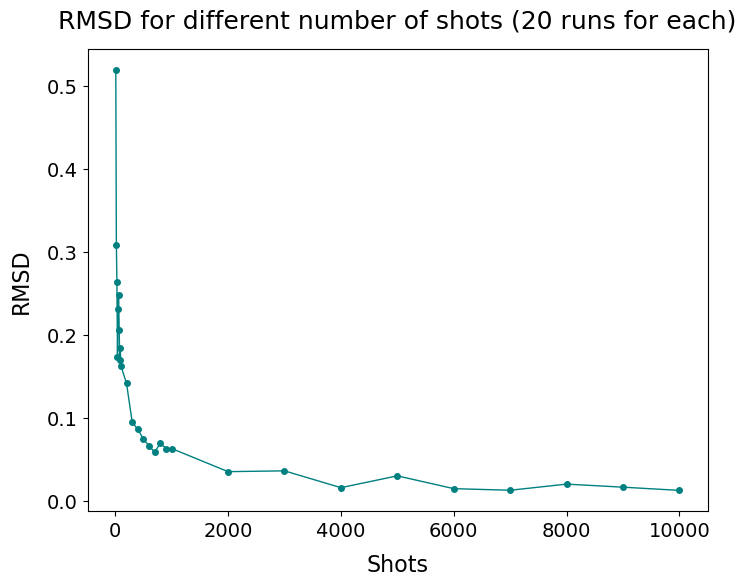

In [ ]:
# Use LaTeX for text rendering
plt.rcParams['text.usetex'] = False
plt.rcParams['font.size'] = 14
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

# Create figure
fig, ax = plt.subplots(figsize=(8,6))
# fig.patch.set_facecolor('#FAFAFA')
# ax.set_facecolor('#FAFAFA')

# Plot with error bars
ax.plot(n_shotss, rmsds, color='teal', markersize=4, marker="o", lw=1)

# Titles and labels
ax.set_title(f"RMSD for different number of shots ({number_of_runs} runs for each)", pad=15)
ax.set_xlabel("Shots", labelpad=10)
ax.set_ylabel("RMSD", labelpad=10)


# Tight layout
# plt.tight_layout()

# Show plot
plt.show()
# fig.savefig(f"Plots/rmsd_{n_shotss[0]}_{n_shotss[-1]}_{number_of_runs}r.pdf", dpi=800)

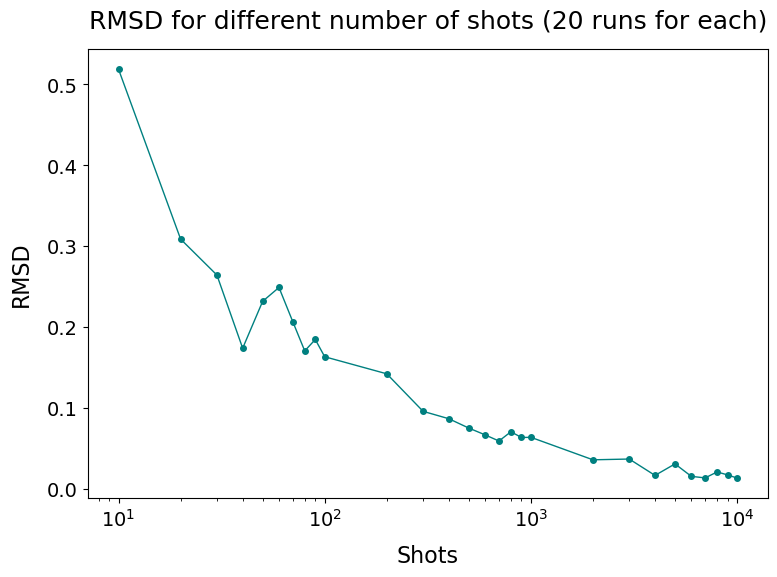

In [537]:
# Use LaTeX for text rendering
plt.rcParams['text.usetex'] = False
plt.rcParams['font.size'] = 14
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

# Create figure
fig, ax = plt.subplots(figsize=(8,6))
# fig.patch.set_facecolor('#FAFAFA')
# ax.set_facecolor('#FAFAFA')

# Plot with error bars
ax.plot(n_shotss, rmsds, color='teal', markersize=4, marker="o", lw=1)

# Titles and labels
ax.set_title(f"RMSD for different number of shots ({number_of_runs} runs for each)", pad=15)
ax.set_xlabel(r"Shots", labelpad=10)
ax.set_ylabel(r"RMSD", labelpad=10)
ax.set_xscale('log')



# Tight layout
plt.tight_layout()

# Show plot
plt.show()
# fig.savefig(f"Plots/rmsd_{n_shotss[0]}_{n_shotss[-1]}_{number_of_runs}r_log.pdf", dpi=800)

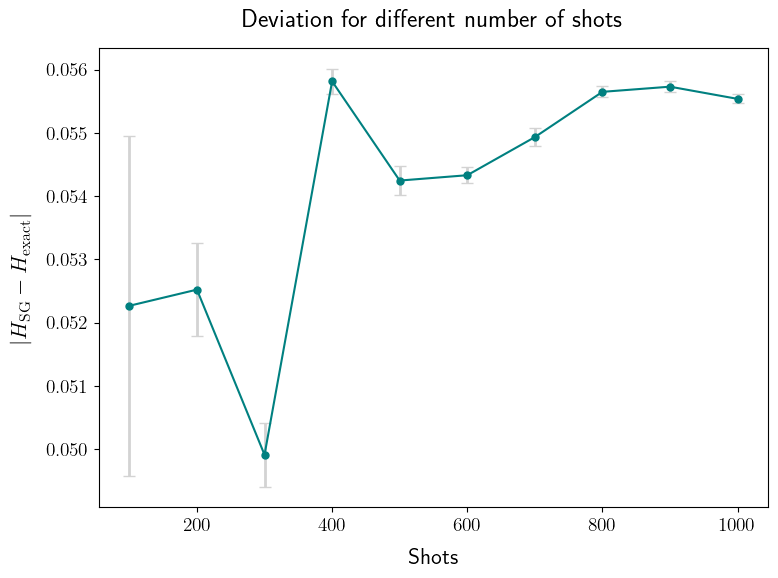

In [95]:
# Use LaTeX for text rendering
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 14
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

# Create figure
fig, ax = plt.subplots(figsize=(8,6))
# fig.patch.set_facecolor('#FAFAFA')
# ax.set_facecolor('#FAFAFA')

# Plot with error bars
ax.errorbar(x=n_shotss, 
            y=np.mean(distances, axis=0), 
            yerr=np.std(distances, axis=0) / np.sqrt(n_shotss), 
            fmt='o-', color="teal", ecolor='lightgray', elinewidth=2, capsize=4, markersize=5)

# Titles and labels
ax.set_title(r"Deviation for different number of shots", pad=15)
ax.set_xlabel(r"Shots", labelpad=10)
ax.set_ylabel(r"$|H_{\mathrm{SG}} - H_{\mathrm{exact}}|$", labelpad=10)


# Tight layout
plt.tight_layout()

# Show plot
plt.show()
fig.savefig(f"Plots/shadow_grouping_error_{n_shotss[0]}_{n_shotss[-1]}_no_MM.pdf", dpi=800)

# Molecular Hamiltonians

### $\text{H}_2$ molecule
Load data

In [15]:
H2datasets = qml.data.load("qchem", molname="H2", bondlength=0.742, basis="STO-3G")
# H2datasets = qml.data.load("qchem", molname="NH3", bondlength=1.013, basis="STO-3G")
H2data = H2datasets[0]
H2_ham = H2data.hamiltonian

In [17]:
H2_ham

(
    -0.09963387941370971 * I(0)
  + 0.17110545123720233 * Z(0)
  + 0.17110545123720225 * Z(1)
  + 0.16859349595532533 * (Z(0) @ Z(1))
  + 0.04533062254573469 * (Y(0) @ X(1) @ X(2) @ Y(3))
  + -0.04533062254573469 * (Y(0) @ Y(1) @ X(2) @ X(3))
  + -0.04533062254573469 * (X(0) @ X(1) @ Y(2) @ Y(3))
  + 0.04533062254573469 * (X(0) @ Y(1) @ Y(2) @ X(3))
  + -0.22250914236600539 * Z(2)
  + 0.12051027989546245 * (Z(0) @ Z(2))
  + -0.22250914236600539 * Z(3)
  + 0.16584090244119712 * (Z(0) @ Z(3))
  + 0.16584090244119712 * (Z(1) @ Z(2))
  + 0.12051027989546245 * (Z(1) @ Z(3))
  + 0.1743207725924201 * (Z(2) @ Z(3))
)

In [18]:
id_coefs = []
non_id_coefs = []
non_id_ops = []
for i in range(len(H2_ham.coeffs)):
    if isinstance(H2_ham.ops[i], qml.Identity):
        id_coefs.append(H2_ham.coeffs[i])
    else:
        non_id_coefs.append(H2_ham.coeffs[i])
        non_id_ops.append(H2_ham.ops[i])

H2_ham_formatted = qml.Hamiltonian(non_id_coefs, non_id_ops)
print("Id coef:", id_coefs)
print("Non-idle part of H:", H2_ham_formatted)

Id coef: [-0.09963387941370971]
Non-idle part of H: 0.17110545123720233 * Z(0) + 0.17110545123720225 * Z(1) + 0.16859349595532533 * (Z(0) @ Z(1)) + 0.04533062254573469 * (Y(0) @ X(1) @ X(2) @ Y(3)) + -0.04533062254573469 * (Y(0) @ Y(1) @ X(2) @ X(3)) + -0.04533062254573469 * (X(0) @ X(1) @ Y(2) @ Y(3)) + 0.04533062254573469 * (X(0) @ Y(1) @ Y(2) @ X(3)) + -0.22250914236600539 * Z(2) + 0.12051027989546245 * (Z(0) @ Z(2)) + -0.22250914236600539 * Z(3) + 0.16584090244119712 * (Z(0) @ Z(3)) + 0.16584090244119712 * (Z(1) @ Z(2)) + 0.12051027989546245 * (Z(1) @ Z(3)) + 0.1743207725924201 * (Z(2) @ Z(3))


In [19]:
dev_exact = qml.device("default.qubit", wires=len(H2_ham.wires), shots=None)
dev_sg = qml.device("lightning.qubit", wires=len(H2_ham.wires), shots=1)
dev_shadow = qml.device("default.qubit", wires=len(H2_ham.wires), shots=5000)


def H2_circuit():
    qml.BasisState(H2data.hf_state, wires=list(H2_ham.wires))
    for op in H2data.vqe_gates:
        qml.apply(op)


@qml.qnode(dev_exact)
def qnode_exact():
    H2_circuit()
    return qml.expval(H2_ham)

H_exact = H2data.fci_energy
print("Exact H2 Hamiltonian:", np.round(H_exact, 5))
print("Almost exact H2 Hamiltonian:", np.round(qnode_exact(), 5))
# print("Almost exact H2 Hamiltonian:", np.round(qnode_exact(), 5))



@qml.qnode(dev_sg)
def qnode_sg(observables):
    H2_circuit()
    return [qml.expval(obs) for obs in observables]


@qml.qnode(dev_shadow)
def qnode_shadow():
    H2_circuit()
    return qml.classical_shadow(wires=list(H2_ham.wires))

bits, recipes = qnode_shadow()
shadow = qml.ClassicalShadow(bits, recipes)

Exact H2 Hamiltonian: -1.13726
Almost exact H2 Hamiltonian: -1.13638


/opt/anaconda3/envs/plane/lib/python3.13/site-packages/pennylane/ops/op_math/composite.py:209: FutureWarning: functools.partial will be a method descriptor in future Python versions; wrap it in staticmethod() if you want to preserve the old behavior
  return self._math_op(math.vstack(eigvals), axis=0)


In [20]:
shadow.expval(H2_ham)

array(-1.12245542)

In [ ]:
# n_shotss = range(100, 1100, 100)
# n_shotss = range(100, 110, 10)
# n_shotss = range(10, 110, 10)
# n_shotss = range(10, 30, 10)
# n_shotss = range(100, 600, 100)
# n_shotss = range(1000, 6000, 1000)
# n_shotss = range(6000, 11000, 1000)

# n_shotss = [50]
# n_shotss = (
#     list(range(1000, 10001, 1000)) +     # 1000 to 10000
#     list(range(20000, 100001, 10000)) +  # 20000 to 100000
#     list(range(200000, 1000001, 100000)) # 200000 to 1000000
# )
# n_shotss = (
#     list(range(10, 110, 10)) +  
#     list(range(200, 1100, 100))
# )
# n_shotss = (
#     list(range(10, 110, 10)) +  
#     list(range(200, 1100, 100)) +
#     list(range(2000, 11000, 1000))
# )

# n_shotss = (
#     list(range(10000, 110000, 10000))
# )


number_of_runs = 20
# number_of_runs = 100
# number_of_runs = 1


rmsds = shadow_grouping_estimation_rmsd(H2_ham_formatted, qnode_sg, number_of_runs, n_shotss, H_exact, 
                                        write_to_file=True, folder_name="Data/H2", offset=sum(id_coefs), verbose=True)


Shots: 10000 	 Time for measurement scheme: 15.536733 s
n_shots              time/run (s)         total_time (s)           
10                   0.0175               0.3493                   
20                   0.0347               0.6941                   
30                   0.0544               1.0872                   
40                   0.0681               1.3624                   
50                   0.0867               1.7338                   
60                   0.1020               2.0409                   
70                   0.1260               2.5206                   
80                   0.1334               2.6686                   
90                   0.1487               2.9739                   
100                  0.1644               3.2870                   
200                  0.3299               6.5988                   
300                  0.4895               9.7891                   
400                  0.6520               13.0405           

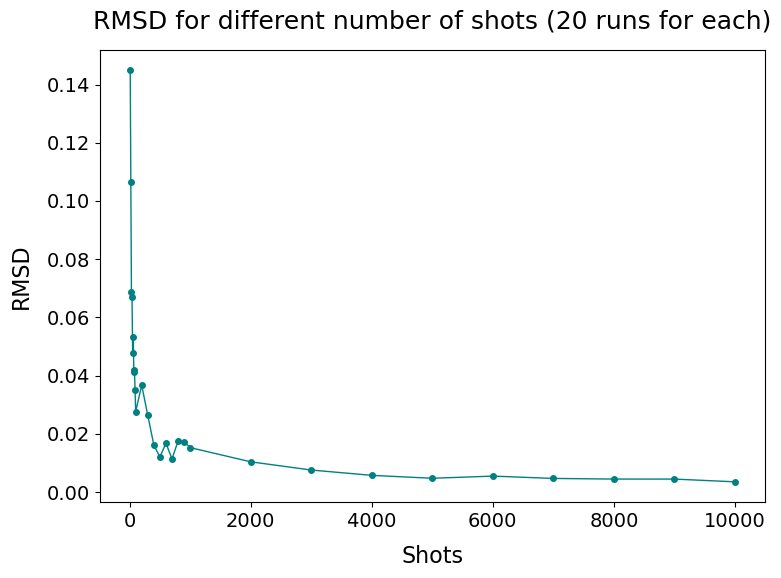

In [548]:
# Use LaTeX for text rendering
plt.rcParams['text.usetex'] = False
plt.rcParams['font.size'] = 14
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

# Create figure
fig, ax = plt.subplots(figsize=(8,6))
# fig.patch.set_facecolor('#FAFAFA')
# ax.set_facecolor('#FAFAFA')

# Plot with error bars
ax.plot(n_shotss, rmsds, color='teal', markersize=4, marker="o", lw=1)

# Titles and labels
ax.set_title(f"RMSD for different number of shots ({number_of_runs} runs for each)", pad=15)
ax.set_xlabel("Shots", labelpad=10)
ax.set_ylabel("RMSD", labelpad=10)


# Tight layout
plt.tight_layout()

# Show plot
plt.show()
fig.savefig(f"Plots/H2_rmsd_{n_shotss[0]}_{n_shotss[-1]}_{number_of_runs}r.pdf", dpi=800)

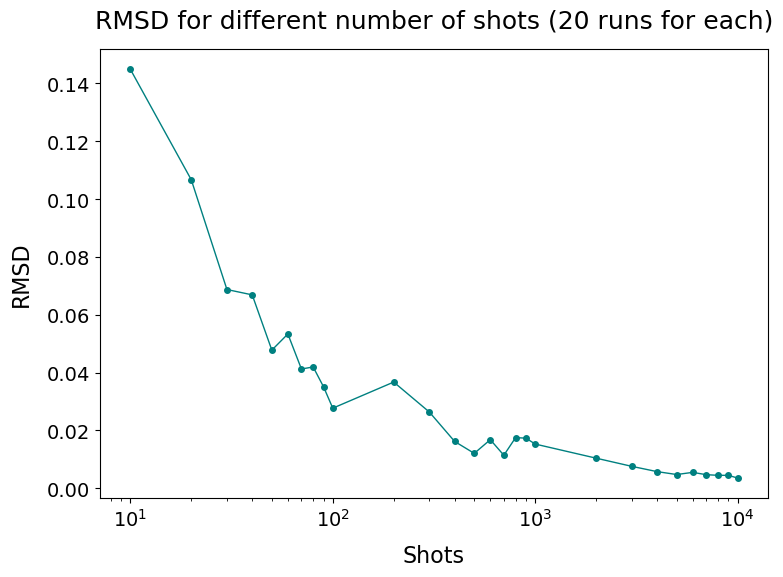

In [550]:
# Use LaTeX for text rendering
plt.rcParams['text.usetex'] = False
plt.rcParams['font.size'] = 14
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

# Create figure
fig, ax = plt.subplots(figsize=(8,6))
# fig.patch.set_facecolor('#FAFAFA')
# ax.set_facecolor('#FAFAFA')

# Plot with error bars
ax.plot(n_shotss, rmsds, color='teal', markersize=4, marker="o", lw=1)

# Titles and labels
ax.set_title(f"RMSD for different number of shots ({number_of_runs} runs for each)", pad=15)
ax.set_xlabel(r"Shots", labelpad=10)
ax.set_ylabel(r"RMSD", labelpad=10)
ax.set_xscale('log')


# Tight layout
plt.tight_layout()

# Show plot
plt.show()
fig.savefig(f"Plots/H2_rmsd_{n_shotss[0]}_{n_shotss[-1]}_{number_of_runs}r_log.pdf", dpi=800)